In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from collections import Counter
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial'] 
plt.rcParams['axes.unicode_minus'] = False

data_dir = 'data/'
df_fragrance_count = pd.read_csv(data_dir + 'fragrance_count.csv') 
df_1976 = pd.read_csv(data_dir + '1976_clean.csv') 
df_note_count = pd.read_csv(data_dir + 'note_class_map.csv') 
df_fragrance_map = pd.read_csv(data_dir + 'fragrance_map.csv') 

fragrance_map = dict(zip(df_fragrance_map['original_fragrance'], df_fragrance_map['fragrance']))
df_1976['fragrance'] = df_1976['fragrance'].map(fragrance_map).fillna(df_1976['fragrance'])

note_class_map = pd.Series(df_note_count['class'].values, index=df_note_count['note']).to_dict()

for note in note_class_map:
    if pd.isna(note_class_map[note]):
        note_class_map[note] = '其他'
# class_trans = {
#     '花香调': '花香调\n(Floral)', '木质调': '木质调\n(Woody)', '东方调': '东方调\n(Oriental)', '柑橘调': '柑橘调\n(Citrus)',
#     '果香调': '果香调\n(Fruity)', '馥奇调': '馥奇调\n(Fougère)', '绿叶调': '绿叶调\n(Green)', '水生调': '水生调\n(Aquatic)',
#     '甘苔调': '甘苔调\n(Chypre)', '皮革调': '皮革调\n(Leather)', '美食调': '美食调\n(Gourmand)', '辛香调': '辛香调\n(Spicy)',
#     '醛香调': '醛香调\n(Aldehyde)', '素心兰调': '素心兰调\n(Chypre)', '清新调': '清新调\n(Fresh)', '其他': '其他\n(Other)',
#     '男性': 'Male', '女性': 'Female', '中性': 'Neutral',
#     'male': 'Male', 'female': 'Female', 'neutral': 'Neutral',
#     '木质香调': '木质调\n(Woody)', '美食香调': '美食调\n(Gourmand)', '皮革香调': '皮革调\n(Leather)', 
#     '青香调': '绿叶调\n(Green)', '海洋调': '水生调\n(Aquatic)', '麝香调': '麝香调\n(Musk)', 
#     '柑苔香调': '甘苔调\n(Chypre)', '树脂调': '树脂调\n(Resinous)', '概念性': '概念性\n(Conceptual)'
# }
class_trans = {
    '花香调': '花香调\nFloral', '木质调': '木质调\nWoody', '东方调': '东方调\nOriental', '柑橘调': '柑橘调\nCitrus',
    '果香调': '果香调\nFruity', '馥奇调': '馥奇调\nFougère', '绿叶调': '绿叶调\nGreen', '水生调': '水生调\nAquatic',
    '甘苔调': '甘苔调\nChypre', '皮革调': '皮革调\nLeather', '美食调': '美食调\nGourmand', '辛香调': '辛香调\nSpicy',
    '醛香调': '醛香调\nAldehyde', '素心兰调': '素心兰调\nChypre', '清新调': '清新调\nFresh', '其他': '其他\nOther',
    '男性': 'Male', '女性': 'Female', '中性': 'Neutral',
    'male': 'Male', 'female': 'Female', 'neutral': 'Neutral',
    '木质香调': '木质调\nWoody', '美食香调': '美食调\nGourmand', '皮革香调': '皮革调\nLeather', 
    '青香调': '绿叶调\nGreen', '海洋调': '水生调\nAquatic', '麝香调': '麝香调\nMusk', 
    '柑苔香调': '甘苔调\nChypre', '树脂调': '树脂调\nResinous', '概念性': '概念性\nConceptual'
}


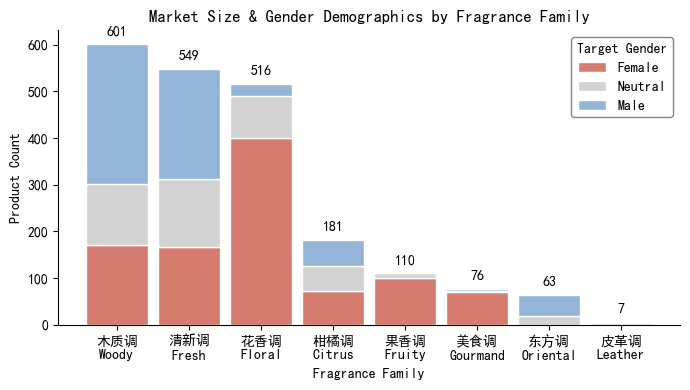

In [2]:
# 1. Fragrance Distribution by Gender Composition

plt.figure(figsize=(7, 4))

valid_genders = ['male', 'female', 'neutral']
df_stack = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_stack['fragrance_en'] = df_stack['fragrance'].map(class_trans).fillna(df_stack['fragrance'])

ct_stack = pd.crosstab(df_stack['fragrance_en'], df_stack['gender'])

ct_stack['Total'] = ct_stack.sum(axis=1)
ct_stack = ct_stack.sort_values('Total', ascending=False)

categories = ct_stack.index
genders_order = ['female', 'neutral', 'male'] 
data_bottom = np.zeros(len(categories))

colors = {'female': '#D57B70', 'neutral': '#D2D2D2', 'male': '#94B5D8'}
labels = {'female': 'Female', 'neutral': 'Neutral', 'male': 'Male'}

for gender in genders_order:
    if gender in ct_stack.columns:
        values = ct_stack[gender].values
        plt.bar(categories, values, bottom=data_bottom, label=labels[gender], 
                color=colors[gender], edgecolor='white', width=0.85, linewidth=1)
        data_bottom += values

plt.title('Market Size & Gender Demographics by Fragrance Family')
plt.xlabel('Fragrance Family')
plt.ylabel('Product Count')

plt.legend(title='Target Gender', loc='upper right', frameon=True, framealpha=0.95, shadow=False, edgecolor='gray')

for i, total in enumerate(ct_stack['Total']):
    plt.text(i, total + 15, f"{int(total)}", ha='center', va='bottom')

plt.grid(False)
sns.despine()
plt.tight_layout()
plt.savefig("img/Market Size & Gender Demographics by Fragrance Family.png", dpi=300)
plt.show()

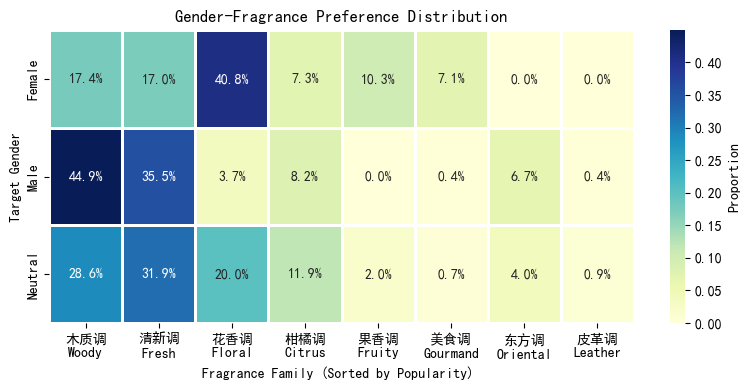

In [3]:
# 2. Gender-Fragrance Heatmap - Publication Quality
valid_genders = ['male', 'female', 'neutral']
df_heatmap = df_1976[df_1976['gender'].isin(valid_genders)].copy()

df_heatmap['fragrance_en'] = df_heatmap['fragrance'].map(class_trans).fillna(df_heatmap['fragrance'])
df_heatmap['gender_en'] = df_heatmap['gender'].map(class_trans).fillna(df_heatmap['gender'])

ct = pd.crosstab(df_heatmap['gender_en'], df_heatmap['fragrance_en'], normalize='index')

col_order = df_heatmap['fragrance_en'].value_counts().index
col_order = [c for c in col_order if c in ct.columns]
ct_sorted = ct[col_order]

plt.figure(figsize=(8, 4)) 

sns.heatmap(ct_sorted, annot=True, fmt='.1%', cmap='YlGnBu', 
            cbar_kws={'label': 'Proportion'},
            linewidths=1.0, linecolor='white')

plt.title('Gender-Fragrance Preference Distribution')
plt.xlabel('Fragrance Family (Sorted by Popularity) ')
plt.ylabel('Target Gender')

plt.tight_layout()
plt.savefig("img/Gender-Fragrance Preference Distribution Heatmap.png", dpi=300)
plt.show()

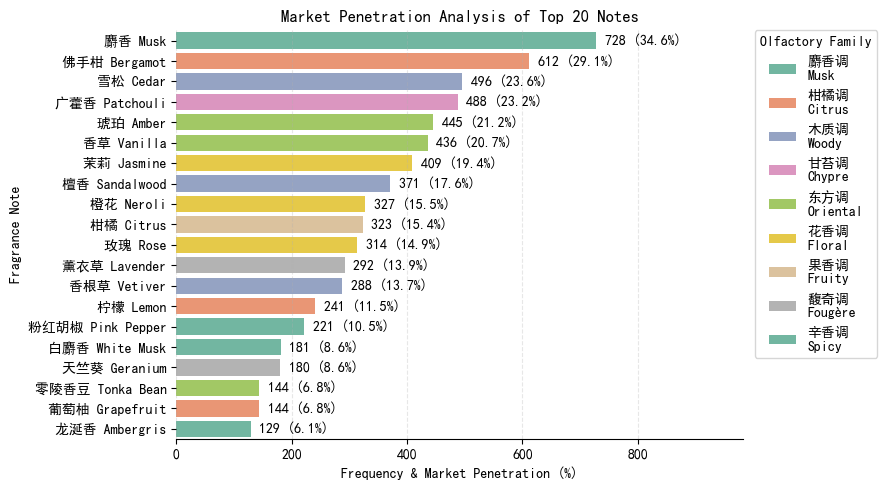

In [4]:
# 3. Note Frequency Top-K - Market Penetration Analysis

top_k = 20
total_perfumes = len(df_1976) 

df_top_notes = df_note_count.sort_values('count', ascending=False).head(top_k).copy()

# note_trans = {
#     '麝香': '麝香 (Musk)', '佛手柑': '佛手柑 (Bergamot)', '雪松': '雪松 (Cedar)', 
#     '广藿香': '广藿香 (Patchouli)', '琥珀': '琥珀 (Amber)', '香草': '香草 (Vanilla)', 
#     '茉莉': '茉莉 (Jasmine)', '檀香': '檀香 (Sandalwood)', '橙花': '橙花 (Neroli)', 
#     '柑橘': '柑橘 (Citrus)', '玫瑰': '玫瑰 (Rose)', '薰衣草': '薰衣草 (Lavender)', 
#     '香根草': '香根草 (Vetiver)', '柠檬': '柠檬 (Lemon)', '粉红胡椒': '粉红胡椒 (Pink Pepper)', 
#     '白麝香': '白麝香 (White Musk)', '天竺葵': '天竺葵 (Geranium)', '零陵香豆': '零陵香豆 (Tonka Bean)', 
#     '葡萄柚': '葡萄柚 (Grapefruit)', '龙涎香': '龙涎香 (Ambergris)'
# }
note_trans = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris'
}
df_top_notes['note_en'] = df_top_notes['note'].map(note_trans).fillna(df_top_notes['note'])

df_top_notes['class'] = df_top_notes['class'].fillna('Other')
df_top_notes['class_en'] = df_top_notes['class'].map(class_trans).fillna(df_top_notes['class'])

df_top_notes['percentage'] = df_top_notes['count'] / total_perfumes * 100 

plt.figure(figsize=(9, 5)) 

ax = sns.barplot(data=df_top_notes, y='note_en', x='count', hue='class_en', dodge=False, palette='Set2')

plt.title(f'Market Penetration Analysis of Top {top_k} Notes')
plt.xlabel('Frequency & Market Penetration (%)')
plt.ylabel('Fragrance Note')

plt.legend(title='Olfactory Family', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=True)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    if width > 0: 
        percentage = (width / total_perfumes) * 100
        label_text = f'{int(width)} ({percentage:.1f}%)'
        ax.text(width + 15, p.get_y() + p.get_height()/2.,
                label_text,
                ha='left', va='center', color='black')

max_width = df_top_notes['count'].max()
plt.xlim(0, max_width * 1.35)

plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.savefig("img/Top-K Note Frequency Market Penetration Analysis.png", dpi=300)
plt.show()

In [57]:
# 4. Sankey Diagram - Olfactory Pyramid Structure Analysis

def get_dominant_class_en(notes_str):
    if pd.isna(notes_str): return None
    notes = [n.strip() for n in notes_str.replace('、', ',').split(',')]
    classes = [note_class_map.get(n, '其他') for n in notes]
    if not classes: return 'Other'
    dom_class = Counter(classes).most_common(1)[0][0]
    trans_map = {
        '花香调': '花香调 Floral', '木质调': '木质调 Woody', '东方调': '东方调 Oriental', 
        '柑橘调': '柑橘调 Citrus', '果香调': '果香调 Fruity', '馥奇调': '馥奇调 Fougère', 
        '绿叶调': '绿叶调 Green', '水生调': '水生调 Aquatic', '甘苔调': '甘苔调 Chypre', 
        '皮革调': '皮革调 Leather', '美食调': '美食调 Gourmand', '辛香调': '辛香调 Spicy',
        '醛香调': '醛香调 Aldehyde', '素心兰调': '素心兰调 Chypre', '清新调': '清新调 Fresh', 
        '其他': '其他 Other',
        '木质香调': '木质调 Woody', '美食香调': '美食调 Gourmand', '皮革香调': '皮革调 Leather', 
        '青香调': '青香调 Green', '海洋调': '海洋调 Marine', '麝香调': '麝香调 Musk', 
        '柑苔香调': '柑苔调 Chypre', '树脂调': '树脂调 Resinous', '概念性': '概念性 Conceptual'
    }
    if dom_class not in trans_map and dom_class in class_trans:
        val = class_trans[dom_class]
        if '\n' in val:
            trans_map[dom_class] = val.replace('\n', ' ')
    return trans_map.get(dom_class, dom_class)

sankey_data = []
for _, row in df_1976.iterrows():
    top = get_dominant_class_en(row['top_notes'])
    mid = get_dominant_class_en(row['middle_notes'])
    base = get_dominant_class_en(row['base_notes'])
    if top and mid:
        sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
    if mid and base:
        sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

df_sankey = pd.DataFrame(sankey_data)
df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
df_sankey = df_sankey[df_sankey['value'] > 30] 

all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
node_map = {node: i for i, node in enumerate(all_nodes)}
node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = all_nodes,
      color = node_colors
    ),
    link = dict(
      source = [node_map[s] for s in df_sankey['source']],
      target = [node_map[t] for t in df_sankey['target']],
      value = df_sankey['value'],
      color = "rgba(200, 200, 200, 0.5)" 
  ))])

fig.update_layout(
    title={'text': "Structural Analysis of Olfactory Pyramid Flow", 'x': 0.5, 'xanchor': 'center'},
    font_size=16,
    width=900,
    height=600,
    template='plotly_white',
    margin=dict(t=60, l=10, r=10, b=10)
)
fig.write_image("img/Olfactory_Pyramid_Sankey.png", scale=3)
fig.show()

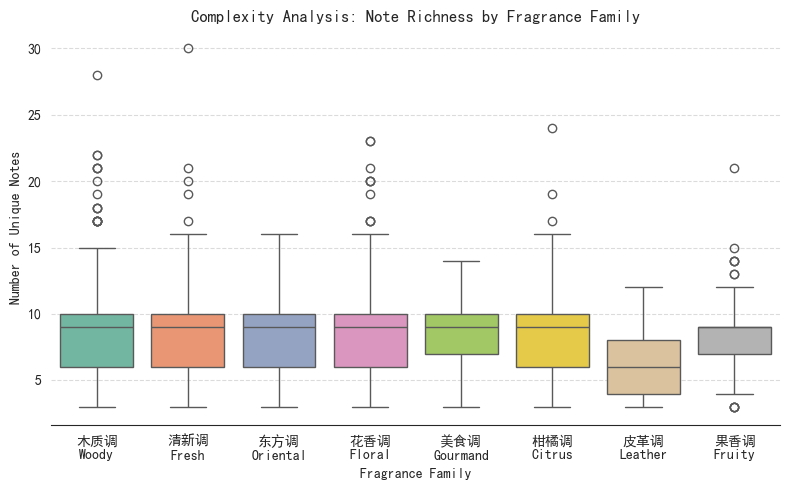

In [69]:
# 5. Note Richness vs Fragrance Type (Boxplot) - Complexity Analysis

def count_notes(row):
    notes = []
    for col in ['top_notes', 'middle_notes', 'base_notes']:
        if pd.notna(row[col]):
            notes.extend(row[col].replace('、', ',').split(','))
    return len(set(notes))

df_1976['note_count'] = df_1976.apply(count_notes, axis=1)
df_1976['fragrance_en'] = df_1976['fragrance'].map(class_trans).fillna(df_1976['fragrance'])

top_fragrances = df_1976['fragrance_en'].value_counts().head(12).index
df_box = df_1976[df_1976['fragrance_en'].isin(top_fragrances)]

plt.figure(figsize=(8, 5))

sns.boxplot(x='fragrance_en', y='note_count', data=df_box, palette="Set2")

plt.title('Complexity Analysis: Note Richness by Fragrance Family')
plt.xlabel('Fragrance Family')
plt.ylabel('Number of Unique Notes')

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("img/Complexity Analysis Note Richness by Fragrance Family.png", dpi=300)
plt.show()

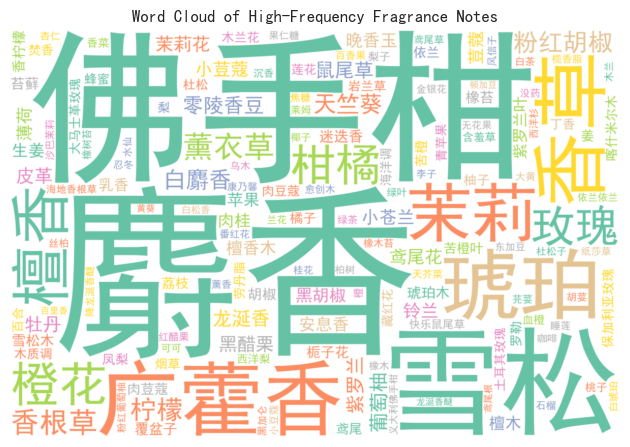

In [42]:
#6. Note Word Cloud
from wordcloud import WordCloud
import os

frequencies = df_note_count.set_index('note')['count'].to_dict()

font_path = 'C:/Windows/Fonts/simhei.ttf'
if not os.path.exists(font_path):
    import matplotlib.font_manager
    try:
        font_path = matplotlib.font_manager.findfont(matplotlib.font_manager.FontProperties(family=['SimHei']))
    except:
        font_path = None 

wc = WordCloud(
    font_path=font_path,
    background_color='white',
    width=1200,
    height=800,
    max_words=150,
    colormap='Set2',
    random_state=42,
    prefer_horizontal=0.9
)

wc.generate_from_frequencies(frequencies)

plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of High-Frequency Fragrance Notes')
plt.tight_layout()
plt.savefig("img/Word Cloud of High-Frequency Fragrance Notes.png", dpi=400)
plt.show()

In [15]:
# 7. Market Composition Sunburst - Hierarchical View

df_sunburst = df_1976[df_1976['gender'].isin(['male', 'female', 'neutral'])].copy()

simple_trans_map = {k: v.split('\n')[0] + ' ' + v.split('\n')[1] for k, v in class_trans.items() if '\n' in v}
simple_trans_map.update({'male': 'Male', 'female': 'Female', 'neutral': 'Neutral'})

df_sunburst['gender_en'] = df_sunburst['gender'].map(simple_trans_map).fillna(df_sunburst['gender'])
df_sunburst['fragrance_en'] = df_sunburst['fragrance'].map(simple_trans_map).fillna(df_sunburst['fragrance'])

df_sb_count = df_sunburst.groupby(['gender_en', 'fragrance_en']).size().reset_index(name='count')
df_sb_count = df_sb_count[df_sb_count['count'] > 20]

fig = px.sunburst(
    df_sb_count, 
    path=['gender_en', 'fragrance_en'], 
    values='count',
    color='gender_en',
    color_discrete_map={
        'Female': '#D57B70',
        'Neutral': '#D2D2D2',
        'Male': '#94B5D8',
        '(?)': '#D2D2D2'
    },
    title='Market Composition Hierarchy'
)

fig.update_layout(
    width=600,
    height=600,
    margin=dict(t=80, l=10, r=10, b=10),
    font_size=16,
    template='plotly_white',
    title={'text': 'Market Composition Hierarchy', 'x': 0.5, 'xanchor': 'center'}
)
fig.update_traces(textinfo="label+percent parent")

fig.write_image("img/Market_Composition_Sunburst.png", scale=3)
fig.show()


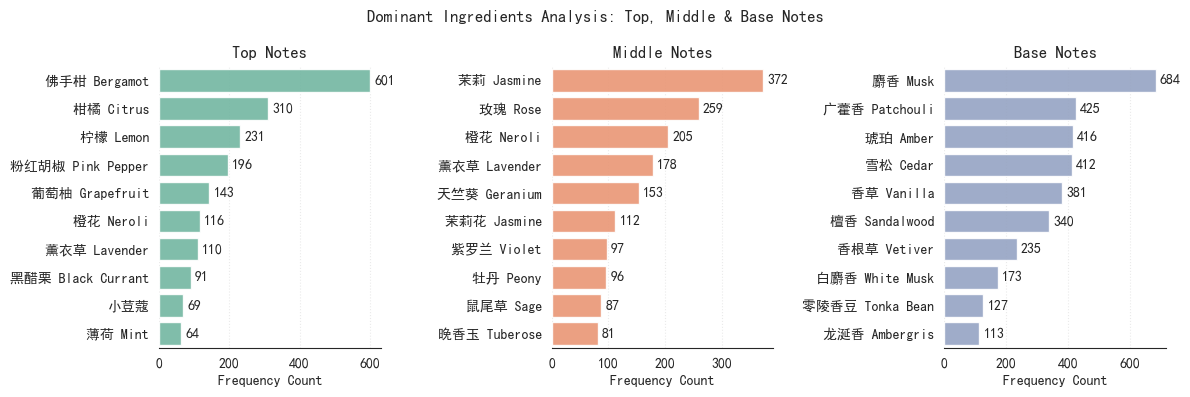

In [ ]:
# 8. Top 10 Notes Distribution by Olfactory Pyramid Position

def get_note_counts(df, column):
    all_notes = []
    for notes in df[column].dropna():
        cleaned = notes.replace('、', ',').replace(' ', '')
        all_notes.extend([n.strip() for n in cleaned.split(',') if n.strip()])
    return pd.Series(Counter(all_notes)).sort_values(ascending=False)

top_counts = get_note_counts(df_1976, 'top_notes').head(10)
mid_counts = get_note_counts(df_1976, 'middle_notes').head(10)
base_counts = get_note_counts(df_1976, 'base_notes').head(10)

# note_trans_map = {
#     '麝香': '麝香 (Musk)', '佛手柑': '佛手柑 (Bergamot)', '雪松': '雪松 (Cedar)', 
#     '广藿香': '广藿香 (Patchouli)', '琥珀': '琥珀 (Amber)', '香草': '香草 (Vanilla)', 
#     '茉莉': '茉莉 (Jasmine)', '檀香': '檀香 (Sandalwood)', '橙花': '橙花 (Neroli)', 
#     '柑橘': '柑橘 (Citrus)', '玫瑰': '玫瑰 (Rose)', '薰衣草': '薰衣草 (Lavender)', 
#     '香根草': '香根草 (Vetiver)', '柠檬': '柠檬 (Lemon)', '粉红胡椒': '粉红胡椒 (Pink Pepper)', 
#     '白麝香': '白麝香 (White Musk)', '天竺葵': '天竺葵 (Geranium)', '零陵香豆': '零陵香豆 (Tonka Bean)', 
#     '葡萄柚': '葡萄柚 (Grapefruit)', '龙涎香': '龙涎香 (Ambergris)', '依兰': '依兰 (Ylang-Ylang)',
#     '紫罗兰': '紫罗兰 (Violet)', '鸢尾花': '鸢尾花 (Iris)', '橡木苔': '橡木苔 (Oakmoss)',
#     '安息香': '安息香 (Benzoin)', '皮革': '皮革 (Leather)', '黑胡椒': '黑胡椒 (Black Pepper)',
#     '肉豆蔻': '肉豆蔻 (Nutmeg)', '小豆蔻': '小豆蔻 (Cardamom)', '生姜': '生姜 (Ginger)',
#     '薄荷': '薄荷 (Mint)', '罗勒': '罗勒 (Basil)', '鼠尾草': '鼠尾草 (Sage)',
#     '百合': '百合 (Lily)', '铃兰': '铃兰 (Lily of the Valley)', '晚香玉': '晚香玉 (Tuberose)',
#     '桃子': '桃子 (Peach)', '苹果': '苹果 (Apple)', '黑醋栗': '黑醋栗 (Black Currant)',
#     '梨': '梨 (Pear)', '菠萝': '菠萝 (Pineapple)', '椰子': '椰子 (Coconut)',
#     '橘子': '橘子 (Mandarin)', '沉香': '沉香 (Oud)', '劳丹脂': '劳丹脂 (Labdanum)',
#     '牡丹': '牡丹 (Peony)', '小苍兰': '小苍兰 (Freesia)', '香柠檬': '香柠檬 (Bergamot)',
#     '茉莉花': '茉莉花 (Jasmine)', '檀香木': '檀香木 (Sandalwood)', '檀木': '檀木 (Sandalwood)',
#     '雪松木': '雪松木 (Cedar)', '橡苔': '橡苔 (Oakmoss)', '乳香': '乳香 (Frankincense)',
#     '没药': '没药 (Myrrh)', '鸢尾': '鸢尾 (Iris)', '水蜜桃': '水蜜桃 (Peach)',
#     '杏': '杏 (Apricot)', '黑加仑': '黑加仑 (Blackcurrant)', '肉桂': '肉桂 (Cinnamon)',
#     '丁香': '丁香 (Clove)', '芫荽': '芫荽 (Coriander)', '丝柏': '丝柏 (Cypress)',
#     '尤加利': '尤加利 (Eucalyptus)', '无花果': '无花果 (Fig)', '栀子花': '栀子花 (Gardenia)',
#     '风信子': '风信子 (Hyacinth)', '杜松子': '杜松子 (Juniper Berry)', '青柠': '青柠 (Lime)',
#     '木兰': '木兰 (Magnolia)', '苔藓': '苔藓 (Moss)', '桂花': '桂花 (Osmanthus)',
#     '李子': '李子 (Plum)', '藏红花': '藏红花 (Saffron)', '烟草': '烟草 (Tobacco)',
#     '柚子': '柚子 (Yuzu)', '香柠檬': '香柠檬 (Bergamot)'
# }
note_trans_map = {
    '麝香': '麝香 Musk', '佛手柑': '佛手柑 Bergamot', '雪松': '雪松 Cedar', 
    '广藿香': '广藿香 Patchouli', '琥珀': '琥珀 Amber', '香草': '香草 Vanilla', 
    '茉莉': '茉莉 Jasmine', '檀香': '檀香 Sandalwood', '橙花': '橙花 Neroli', 
    '柑橘': '柑橘 Citrus', '玫瑰': '玫瑰 Rose', '薰衣草': '薰衣草 Lavender', 
    '香根草': '香根草 Vetiver', '柠檬': '柠檬 Lemon', '粉红胡椒': '粉红胡椒 Pink Pepper', 
    '白麝香': '白麝香 White Musk', '天竺葵': '天竺葵 Geranium', '零陵香豆': '零陵香豆 Tonka Bean', 
    '葡萄柚': '葡萄柚 Grapefruit', '龙涎香': '龙涎香 Ambergris', '依兰': '依兰 Ylang-Ylang',
    '紫罗兰': '紫罗兰 Violet', '鸢尾花': '鸢尾花 Iris', '橡木苔': '橡木苔 Oakmoss',
    '安息香': '安息香 Benzoin', '皮革': '皮革 Leather', '黑胡椒': '黑胡椒 Black Pepper',
    '肉豆蔻': '肉豆蔻 Nutmeg', '小豆蔻': '小豆蔻 Cardamom', '生姜': '生姜 Ginger',
    '薄荷': '薄荷 Mint', '罗勒': '罗勒 Basil', '鼠尾草': '鼠尾草 Sage',
    '百合': '百合 Lily', '铃兰': '铃兰 Lily of the Valley', '晚香玉': '晚香玉 Tuberose',
    '桃子': '桃子 Peach', '苹果': '苹果 Apple', '黑醋栗': '黑醋栗 Black Currant',
    '梨': '梨 Pear', '菠萝': '菠萝 Pineapple', '椰子': '椰子 Coconut',
    '橘子': '橘子 Mandarin', '沉香': '沉香 Oud', '劳丹脂': '劳丹脂 Labdanum',
    '牡丹': '牡丹 Peony', '小苍兰': '小苍兰 Freesia', '香柠檬': '香柠檬 Bergamot',
    '茉莉花': '茉莉花 Jasmine', '檀香木': '檀香木 Sandalwood', '檀木': '檀木 Sandalwood',
    '雪松木': '雪松木 Cedar', '橡苔': '橡苔 Oakmoss', '乳香': '乳香 Frankincense',
    '没药': '没药 Myrrh', '鸢尾': '鸢尾 Iris', '水蜜桃': '水蜜桃 Peach',
    '杏': '杏 Apricot', '黑加仑': '黑加仑 Blackcurrant', '肉桂': '肉桂 Cinnamon',
    '丁香': '丁香 Clove', '芫荽': '芫荽 Coriander', '丝柏': '丝柏 Cypress',
    '尤加利': '尤加利 Eucalyptus', '无花果': '无花果 Fig', '栀子花': '栀子花 Gardenia',
    '风信子': '风信子 Hyacinth', '杜松子': '杜松子 Juniper Berry', '青柠': '青柠 Lime',
    '木兰': '木兰 Magnolia', '苔藓': '苔藓 Moss', '桂花': '桂花 Osmanthus',
    '李子': '李子 Plum', '藏红花': '藏红花 Saffron', '烟草': '烟草 Tobacco',
    '柚子': '柚子 Yuzu', '香柠檬': '香柠檬 Bergamot'
}

sns.set_style("white")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

positions = ['Top Notes', 'Middle Notes', 'Base Notes']
data_list = [top_counts, mid_counts, base_counts]

colors = ['#66C2A5', '#FC8D62', '#8DA0CB'] 

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4)

for i, (ax, data, title, color) in enumerate(zip(axes, data_list, positions, colors)):
    labels = [note_trans_map.get(n, n) for n in data.index]

    bars = sns.barplot(x=data.values, y=labels, ax=ax, color=color, alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('Frequency Count')
    ax.tick_params(axis='y')
    ax.tick_params(axis='x')

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + max(data.values)*0.02, p.get_y() + p.get_height()/2, 
                f'{int(width)}', ha='left', va='center')
    
    # Remove borders
    sns.despine(left=True, bottom=False, ax=ax)
    
    # Add light grid for readability
    ax.grid(axis='x', linestyle=':', alpha=0.4)
    ax.set_ylabel('') # Remove y-label as it's self-explanatory

plt.suptitle('Dominant Ingredients Analysis: Top, Middle & Base Notes')
plt.tight_layout()
plt.savefig("img/Dominant Ingredients Analysis Top Middle Base Notes.png", dpi=400)
plt.show()

In [ ]:
# Gender-Specific Sankey Diagrams
def plot_gender_sankey(target_gender, title_text, threshold=15, filename=None):
    df_gender = df_1976[df_1976['gender'] == target_gender]
    
    sankey_data = []
    for _, row in df_gender.iterrows():
        top = get_dominant_class_en(row['top_notes'])
        mid = get_dominant_class_en(row['middle_notes'])
        base = get_dominant_class_en(row['base_notes'])
        
        if top and mid:
            sankey_data.append({'source': f"Top: {top}", 'target': f"Mid: {mid}", 'value': 1})
        if mid and base:
            sankey_data.append({'source': f"Mid: {mid}", 'target': f"Base: {base}", 'value': 1})

    if not sankey_data:
        print(f"No data for {target_gender}")
        return

    df_sankey = pd.DataFrame(sankey_data)
    df_sankey = df_sankey.groupby(['source', 'target']).count().reset_index()
    df_sankey = df_sankey[df_sankey['value'] > threshold] 

    all_nodes = list(pd.concat([df_sankey['source'], df_sankey['target']]).unique())
    node_map = {node: i for i, node in enumerate(all_nodes)}

    node_colors = ["#66c2a5" if "Top" in n else "#fc8d62" if "Mid" in n else "#8da0cb" for n in all_nodes]

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 12,
          thickness = 22,
          line = dict(color = "black", width = 0.3),
          label = all_nodes,
          color = node_colors
        ),
        link = dict(
          source = [node_map[s] for s in df_sankey['source']],
          target = [node_map[t] for t in df_sankey['target']],
          value = df_sankey['value'],
          color = "rgba(200, 200, 200, 0.5)" 
      ))])

    fig.update_layout(
        title={'text': title_text, 'x': 0.5, 'xanchor': 'center'},
        font_size=14,
        width=700,
        height=480,
        template='plotly_white',
        margin=dict(t=50, l=5, r=5, b=5)
    )
    if filename:
        fig.write_image(filename, scale=3)
    fig.show()

# Plot for Male
plot_gender_sankey('male', "Olfactory Structure Flow - Male Perfumes", threshold=10, filename="img/sankey_male.png")

# Plot for Female
plot_gender_sankey('female', "Olfactory Structure Flow - Female Perfumes", threshold=20, filename="img/sankey_female.png")

# Plot for Neutral
plot_gender_sankey('neutral', "Olfactory Structure Flow - Neutral Perfumes", threshold=10, filename="img/sankey_neutral.png")